In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get insight data

In [2]:
df = pd.read_csv("./BTC-Daily.csv")

df = df.drop_duplicates()

df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


2014-11-28 to 2022-03-01


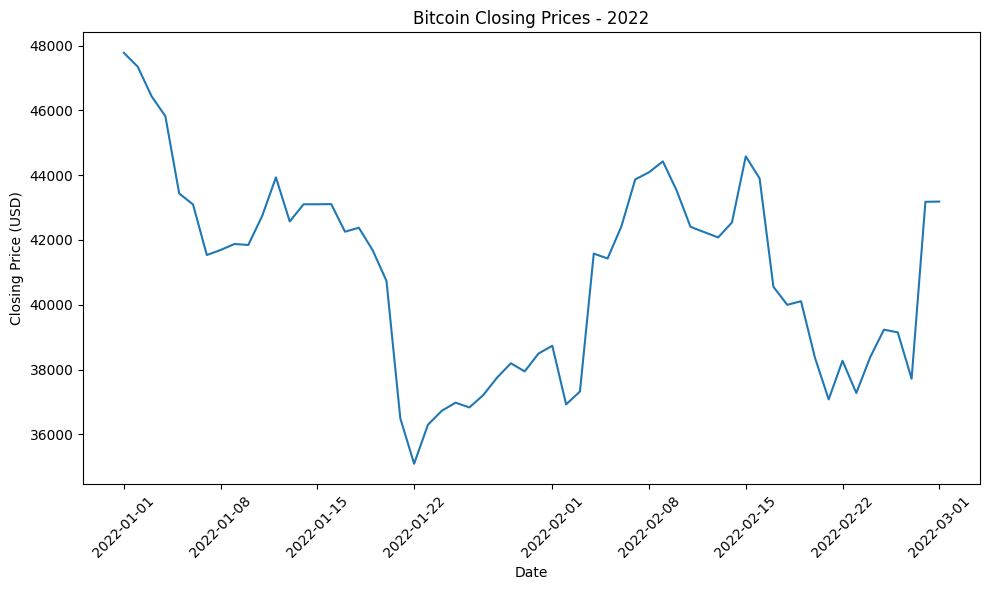

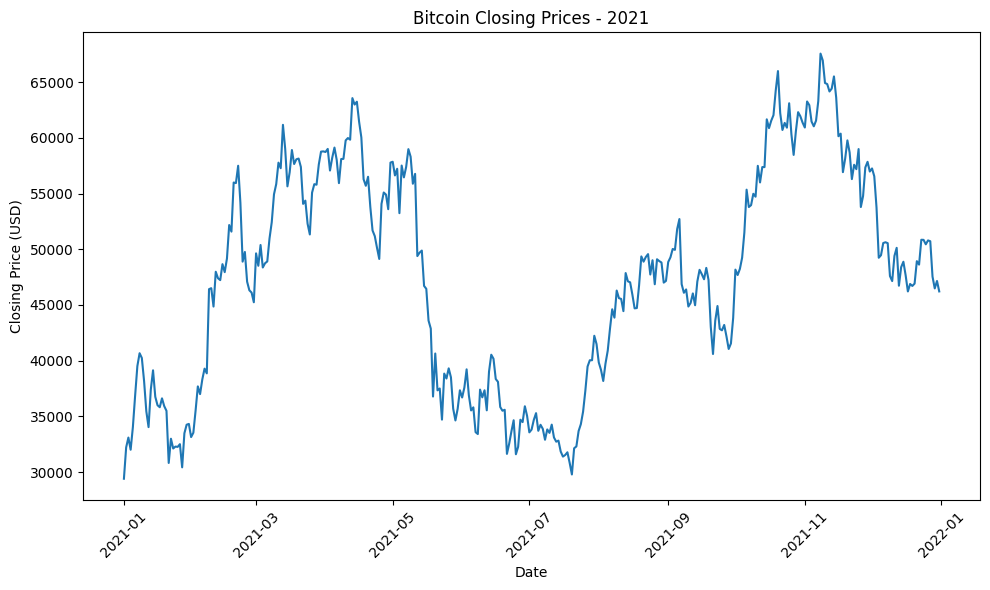

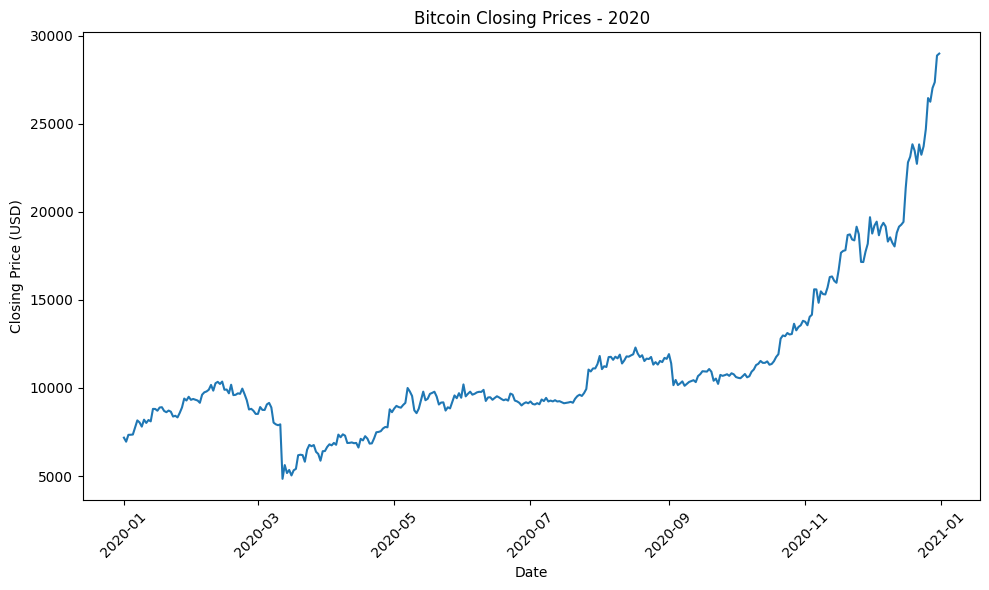

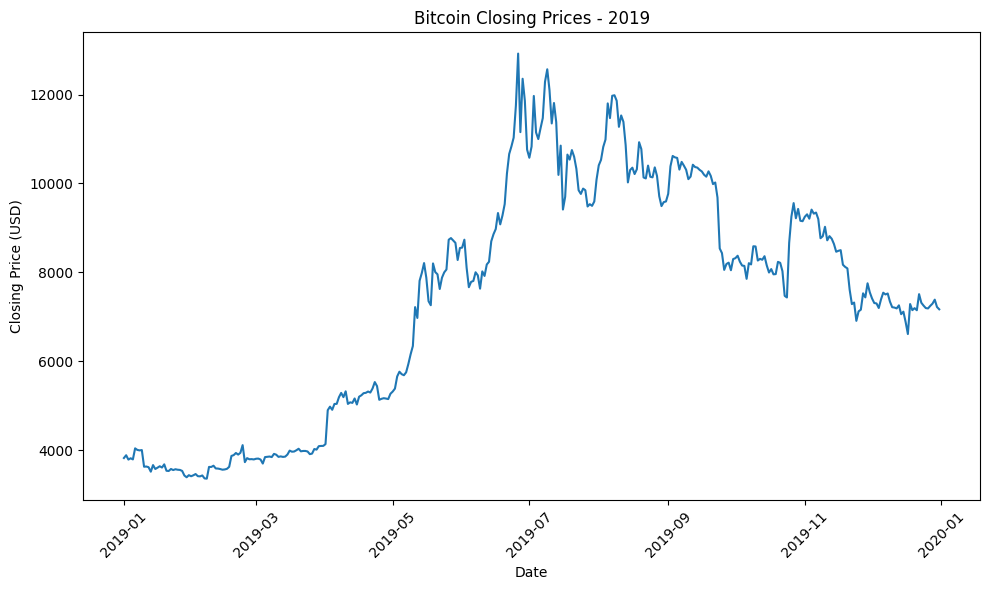

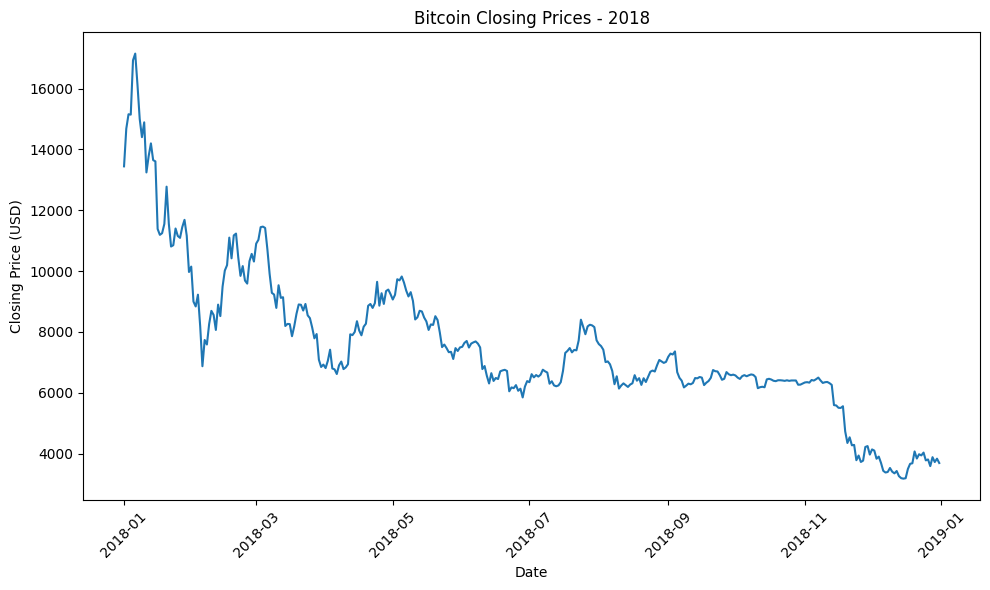

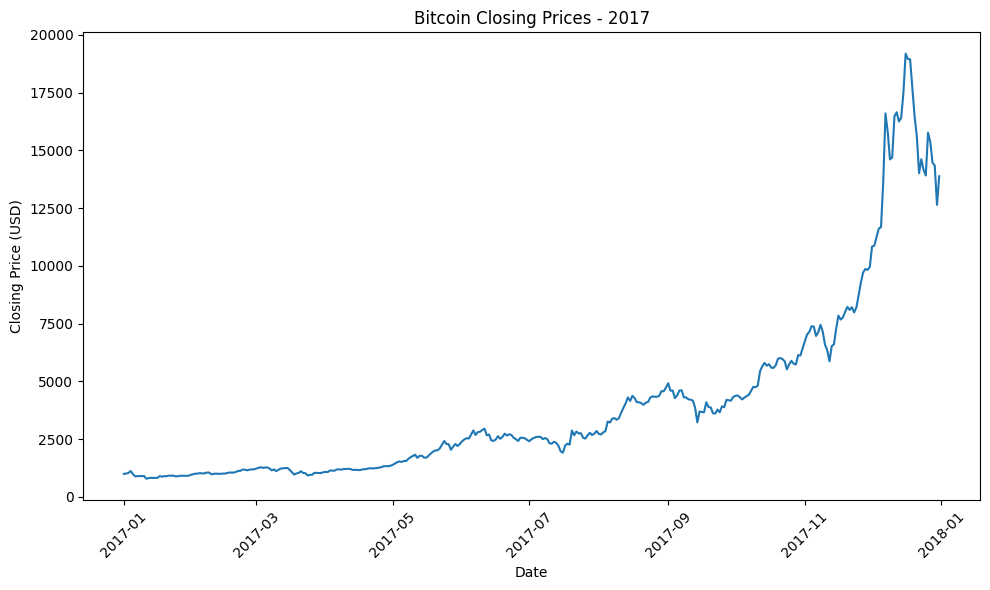

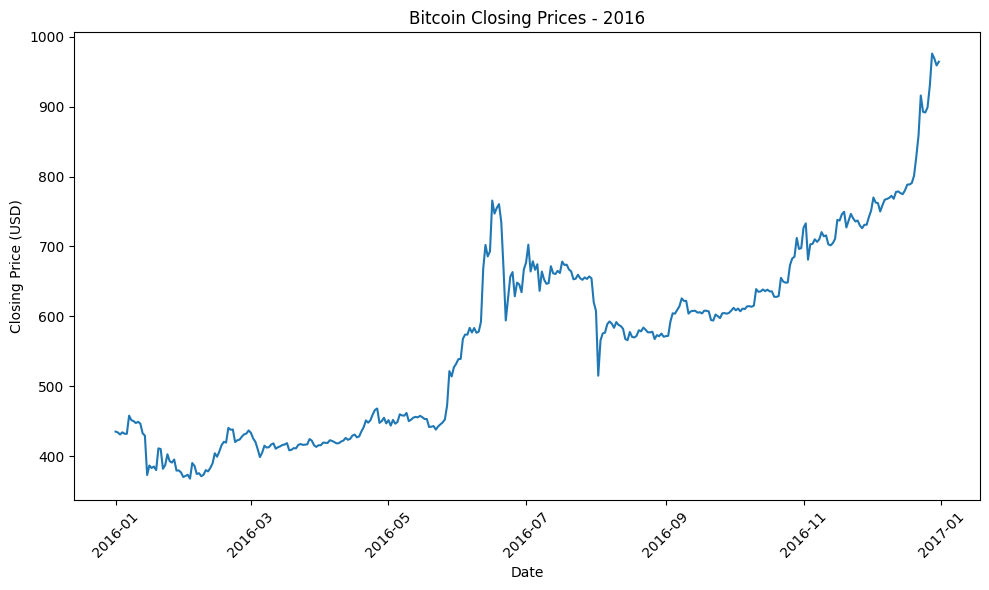

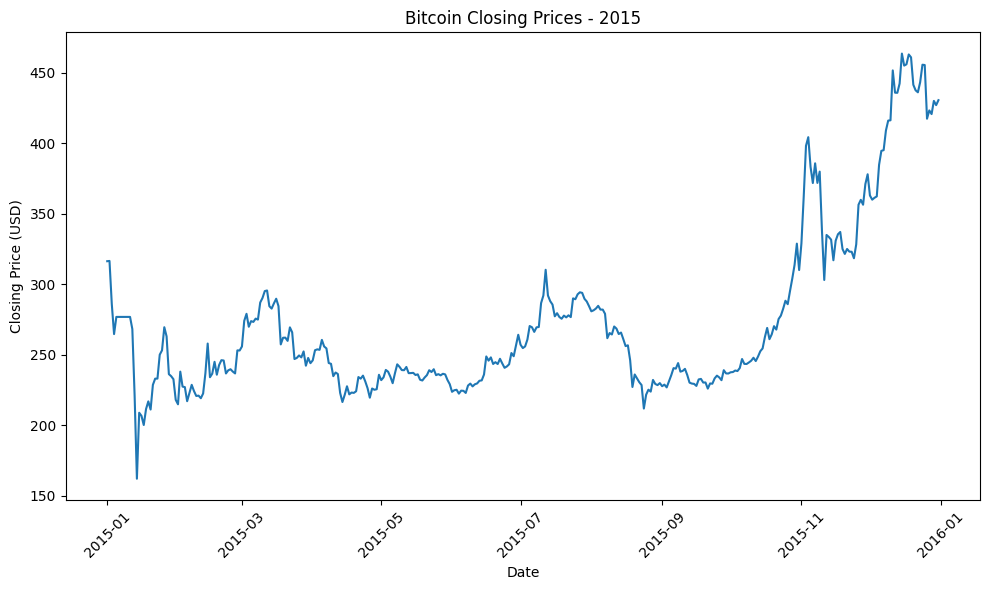

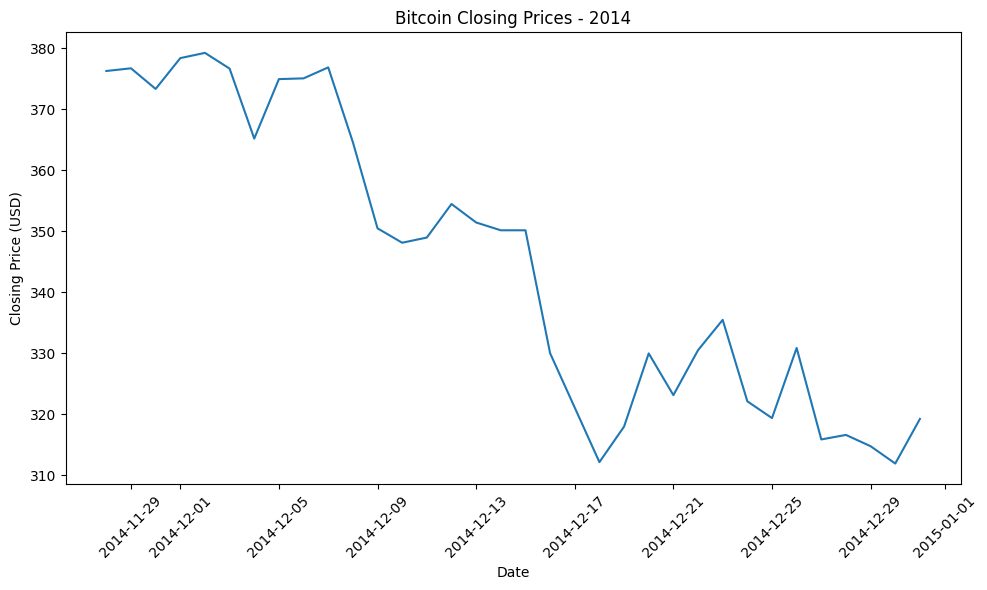

In [3]:
df["date"] = pd.to_datetime(df["date"])

date_range = str(df["date"].dt.date.min()) + " to " + str(df["date"].dt.date.max())

print(date_range)

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

unique_years = df["year"].unique()

for year in unique_years:
    
    year_data = df[df['year'] == year]
    
    year_month_day = year_data[['year', 'month', 'day']].drop_duplicates()
    
    merged_data = pd.merge(year_month_day, df, on=["year", "month", "day"], how= "left")
    
    plt.figure(figsize= (10, 6))
    plt.plot(merged_data['date'], merged_data['close'])
    plt.title(f"Bitcoin Closing Prices - {year}")
    plt.xlabel("Date")
    plt.ylabel("Closing Price (USD)")
    plt.xticks(rotation= 45)
    plt.tight_layout()
    plt.show()

In [4]:
! pip install mplfinance

In [5]:
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import datetime

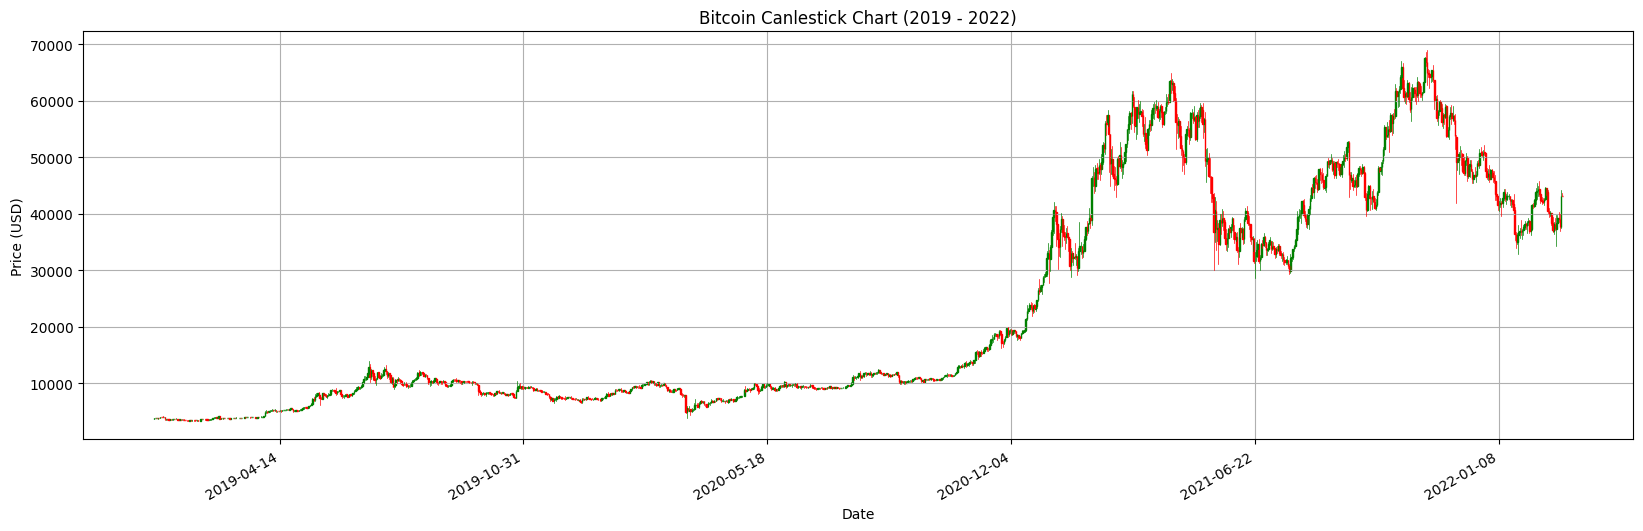

In [6]:
df_filtered = df[(df["date"] >= "2019-01-01") & (df["date"] <= "2022-12-31")].copy()

df_filtered["date_num"] = df_filtered["date"].map(mdates.date2num)

fig, ax = plt.subplots(figsize= (20, 6))

ohlc_data = df_filtered[["date_num", "open", "high", "low", "close"]].values

candlestick_ohlc(ax, ohlc_data, width= 0.6, colorup= "g", colordown= "r")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
fig.autofmt_xdate()

plt.title("Bitcoin Canlestick Chart (2019 - 2022)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)

plt.show()

# Build model linear regression

In [7]:
def predict(X, w, b):
    return np.dot(X, w) + b

def gradient(y_hat, y, x):
    loss_gradient = y_hat - y
    dw = np.dot(x.T, loss_gradient) / len(y)
    db = np.sum(loss_gradient) / len(y)
    cost = np.sum(loss_gradient * 2) / (2 * len(y))
    
    return dw, db, cost

def update_weight(w, b, lr, dw, db):
    w_new = w - lr * dw
    b_new = b - lr * db
    
    return w_new, b_new

# Normalize data

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

y = df["close"]
X = df[["open", "high", "low", "Volume BTC", "Volume USD"]]

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state= 42, shuffle= True)

print(X_train.shape)

(1855, 5)


In [9]:
def linear_regression_vectorized(X, y, learning_rate= 0.01, num_iterations= 200):
    n_sample, n_features = X.shape
    w = np.zeros(n_features)
    b = 0
    losses = []
    
    for _ in range(num_iterations):
        y_hat = predict(X, w, b)
        dw, db, cost = gradient(y_hat, y, X)
        w, b = update_weight(w, b, learning_rate, dw, db)
        losses.append(cost)
    
    return w, b, losses

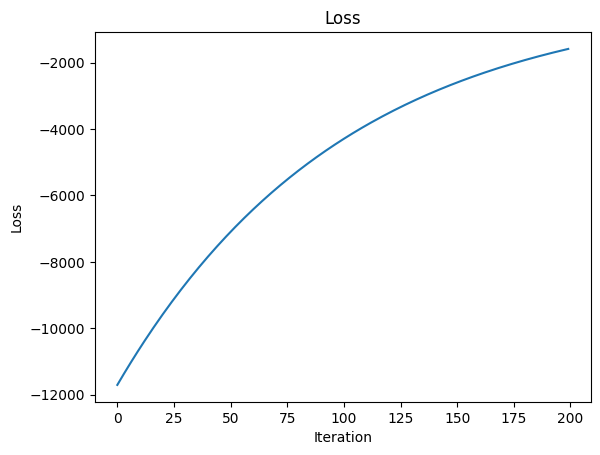

In [10]:
w, b, losses = linear_regression_vectorized(X_train, y_train, learning_rate= 0.01, num_iterations= 200)

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

In [13]:
from sklearn.metrics import r2_score

y_pred = predict(X_test, w, b)

rmse = np.sqrt(np.mean((y_pred - y_test)**2))

mae = np.mean(np.abs(y_pred - y_test))

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

y_train_pred = predict(X_train, w, b)
train_accuracy = r2_score(y_train, y_train_pred)

test_accuracy = r2_score(y_test, y_pred)

print (" Root Mean Square Error ( RMSE ):", round(rmse, 4))
print (" Mean Absolute Error ( MAE):", round(mae, 4))
print (" Training Accuracy (R- squared ):", round(train_accuracy, 4))
print (" Testing Accuracy (R- squared ):", round(test_accuracy, 4))

 Root Mean Square Error ( RMSE ): 1951.7653
 Mean Absolute Error ( MAE): 1715.982
 Training Accuracy (R- squared ): 0.9868
 Testing Accuracy (R- squared ): 0.9851


/tmp/ipykernel_247579/3825599207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019_filter["predicted_close"] = df_2019_filter["close"].shift(1)


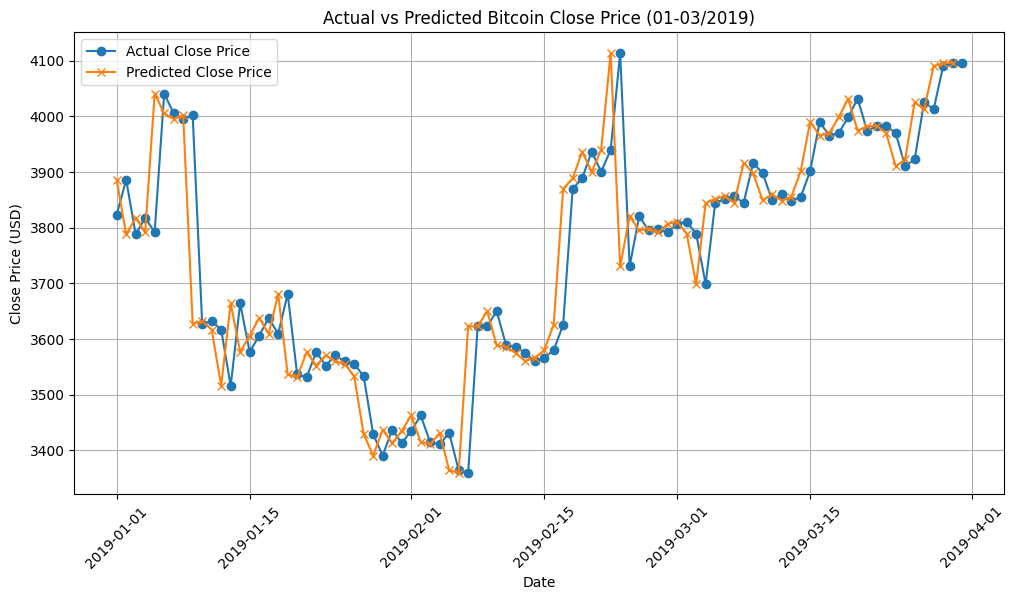

In [15]:
df_2019_filter = df[(df["date"] >= "2019-01-01") & (df["date"] <= "2019-03-31")]

df_2019_filter["predicted_close"] = df_2019_filter["close"].shift(1)

plt.figure(figsize= (12, 6))
plt.plot(df_2019_filter["date"], df_2019_filter["close"], label= "Actual Close Price", marker= "o")
plt.plot(df_2019_filter["date"], df_2019_filter["predicted_close"], label= "Predicted Close Price", marker= "x")
plt.title("Actual vs Predicted Bitcoin Close Price (01-03/2019)")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.xticks(rotation= 45)
plt.legend()
plt.grid(True)
plt.show()